In [1]:
#pip install contractions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import seaborn as sns
import re
import contractions
import warnings
warnings.filterwarnings('ignore')

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import sequence
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

In [3]:
data = pd.read_csv('labeled_data.csv')
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
data.drop(['Unnamed: 0','count','hate_speech','offensive_language',	'neither'],axis=1,inplace=True)
data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


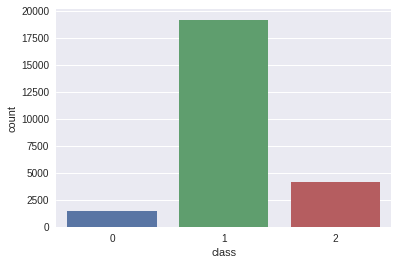

In [6]:
sns.countplot(data['class']);

In [7]:
data['class'].replace({0:1}, inplace=True)
data['class'].replace({2:0}, inplace=True)

In [8]:
data1 = pd.read_csv('train.csv')
data1.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
data1.drop('id',axis=1,inplace=True)
data1.rename(columns={'label':'class'}, inplace=True)
data1.head()

,class,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [10]:
data = pd.concat([data1,data])
data.head()

,class,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


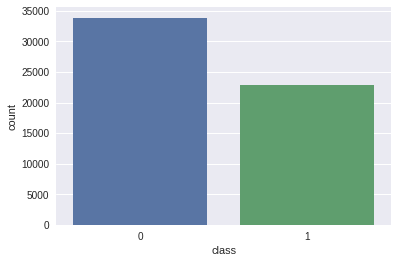

In [11]:
sns.countplot(data['class']);

In [12]:
#Case Conversions
data.tweet = data.tweet.str.lower()
data.head()

,class,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [13]:
#Expand Contractions
data.tweet = data.tweet.apply(lambda item: ' '.join([contractions.fix(word) for word in item.split()]) )
data.head()

,class,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i cannot u...
2,0,bihday your majesty
3,0,#model i love you take with you all the time i...
4,0,factsguide: society now #motivation


In [14]:
#Remove Twitter Handles
data.tweet = data.tweet.str.replace('@','')
data.head()

,class,tweet
0,0,user when a father is dysfunctional and is so ...
1,0,user user thanks for #lyft credit i cannot use...
2,0,bihday your majesty
3,0,#model i love you take with you all the time i...
4,0,factsguide: society now #motivation


In [15]:
#Remove URL Links
data.tweet = data.tweet.str.replace(r"http\S+", ' ')
data.head()

,class,tweet
0,0,user when a father is dysfunctional and is so ...
1,0,user user thanks for #lyft credit i cannot use...
2,0,bihday your majesty
3,0,#model i love you take with you all the time i...
4,0,factsguide: society now #motivation


In [16]:
#Remove Punctuations and Numbers
data['tweet'] = data['tweet'].apply(lambda item: re.sub('[^a-zA-Z]',' ',str(item)))
data.head()

,class,tweet
0,0,user when a father is dysfunctional and is so ...
1,0,user user thanks for lyft credit i cannot use...
2,0,bihday your majesty
3,0,model i love you take with you all the time i...
4,0,factsguide society now motivation


In [17]:
#Remove Whitespace
data['tweet'] = data['tweet'].apply(lambda item: re.sub(r"\s+", " ", item, flags=re.UNICODE))
data.head()

,class,tweet
0,0,user when a father is dysfunctional and is so ...
1,0,user user thanks for lyft credit i cannot use ...
2,0,bihday your majesty
3,0,model i love you take with you all the time i...
4,0,factsguide society now motivation


In [18]:
data['tweet'] = data['tweet'].apply(lambda item: ' '.join([word for word in item.split() if not len(word)<3]) )
data.head()

,class,tweet
0,0,user when father dysfunctional and selfish dra...
1,0,user user thanks for lyft credit cannot use be...
2,0,bihday your majesty
3,0,model love you take with you all the time
4,0,factsguide society now motivation


In [19]:
stopwords = nlp.Defaults.stop_words
stopwords.remove('not')

data['tweet'] = data['tweet'].apply(lambda item: nlp(str(item)))
data['tweet'] = data['tweet'].apply(lambda item: [words.lemma_ for words in item if not words in stopwords])
data['tweet'] = data['tweet'].apply(lambda item: ' '.join([words for words in item]))
data.head()

,class,tweet
0,0,user when father dysfunctional and selfish dra...
1,0,user user thank for lyft credit can not use be...
2,0,bihday -PRON- majesty
3,0,model love -PRON- take with -PRON- all the time
4,0,factsguide society now motivation


In [20]:
x = data['tweet']
y = data['class']

In [21]:
max_words = 50000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
padded_seqeunces = sequence.pad_sequences(sequences, maxlen=max_len)

In [22]:
xtrain,xtest,ytrain,ytest = train_test_split(padded_seqeunces,y,test_size=0.3,random_state=101)

In [23]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape

((39721, 300), (39721,), (17024, 300), (17024,))

In [24]:
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()
model.compile(optimizer=RMSprop(),loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          5000000   
_________________________________________________________________
dropout (Dropout)            (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stop = EarlyStopping(patience=3,monitor='val_accuracy')

In [26]:
model.fit(xtrain,ytrain,callbacks=[early_stop],epochs=5,validation_data=(xtest,ytest))

Epoch 1/5
1242/1242 [==============================] - 398s 318ms/step - loss: 0.2203 - accuracy: 0.9199 - val_loss: 0.1707 - val_accuracy: 0.9412
Epoch 2/5
1242/1242 [==============================] - 397s 320ms/step - loss: 0.1493 - accuracy: 0.9485 - val_loss: 0.1663 - val_accuracy: 0.9429
Epoch 3/5
1242/1242 [==============================] - 397s 320ms/step - loss: 0.1331 - accuracy: 0.9537 - val_loss: 0.1593 - val_accuracy: 0.9424
Epoch 4/5
1242/1242 [==============================] - 397s 320ms/step - loss: 0.1169 - accuracy: 0.9594 - val_loss: 0.1612 - val_accuracy: 0.9420
Epoch 5/5
1242/1242 [==============================] - 406s 327ms/step - loss: 0.1070 - accuracy: 0.9634 - val_loss: 0.1594 - val_accuracy: 0.9463


In [27]:
model.evaluate(xtest,ytest)

532/532 [==============================] - 35s 66ms/step - loss: 0.1594 - accuracy: 0.9463


[0.15940004587173462, 0.9463111162185669]

In [28]:
predictions = model.predict(xtest)

pred = []
for prediction in predictions:
    if prediction[0]<0.45:
        pred.append(0)
    else:
        pred.append(1)

In [29]:
print(confusion_matrix(ytest,pred))
print()
print(classification_report(ytest,pred))

[[9755  325]
 [ 591 6353]]

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     10080
           1       0.95      0.91      0.93      6944

    accuracy                           0.95     17024
   macro avg       0.95      0.94      0.94     17024
weighted avg       0.95      0.95      0.95     17024

